## Dealing with missing data and lift rate effects

In [1]:
import pymc as pm
import pandas as pd
import itertools as itt
import arviz as az
import graphviz
import numpy as np
import importlib as imp

In [2]:
melted_df = pd.read_csv("melted_data.csv")
df = pd.read_csv("data.csv")


In [3]:
full_obs = df.copy()
full_obs = full_obs.dropna()

#lift rates
int_lift_rates = full_obs['Intervention Average Lift Rate'].values.reshape(-1, 1)
base_lift_rates = full_obs['Baseline Average Lift Rate'].values.reshape(-1, 1)

#scores
int_scores = full_obs['Intervention Average Safety Score'].values.reshape(-1, 1)
base_scores = full_obs['Baseline Average Safety Score'].values.reshape(-1, 1)

#treatments
int_treatments = pd.get_dummies(full_obs['Haptic Group'])
tr_names = int_treatments.columns
treatments = int_treatments.values
tr_names

Index(['2 bends in 10 minutes', '2 bends in 5 minutes',
       '3 bends in 8 minutes'],
      dtype='object')

In [11]:
with pm.Model() as m:
    
    #register the data
    scores = pm.Data("scores", np.concatenate([base_scores, int_scores]))    
    
    b_rates = pm.Data("baseline_rates", base_lift_rates)  
    i_rates = pm.Data("intervention_rates", int_lift_rates)  
    
    treats = pm.Data("treatments", treatments)  
    no_treats = pm.Data("baseline", np.zeros(treatments.shape))  
    
    #priors
    α = pm.Normal("lift_alpha", 0, sigma=10)
    lift_treatment = pm.Normal("lift_treatment", 0, sigma=10, shape=(treatments.shape[1], 1))
    ind_effect_sigma = pm.HalfCauchy("lift_ind_error", beta=3)
    ind_effects = pm.Normal("lift_fixed", 0, sigma=ind_effect_sigma, shape=(base_lift_rates.shape[0], 1))

    #obtain impact of treatment to lift scores    
    pred_lift_rates = α + b_rates + ind_effects + pm.math.dot(treats, lift_treatment)
    
    #estimate intervention lift rates
    residual_var = pm.HalfCauchy("lift_error", beta=5)
    est_int_rates = pm.Normal('lift_int', mu=pred_lift_rates, sigma = residual_var, observed = i_rates)
    
    #stack the data together
    lift_rates_stacked = pm.math.concatenate([b_rates, est_int_rates], axis=0)
    treatments_stacked = pm.math.concatenate([no_treats, treats], axis=0)
    
    #priors
    alpha = pm.Normal("score_alpha", 0, sigma=50)
    lift_beta = pm.Normal("score_lift", 0, sigma=10)
    treatment_betas = pm.Normal("score_treatment", 0, sigma=10, shape=(treatments.shape[1], 1))
    score_ind_effect_sigma = pm.HalfCauchy("score_ind_error", beta=3)
    fixed_effects = pm.Normal("score_fixed", 0, sigma=score_ind_effect_sigma, shape=(base_lift_rates.shape[0], 1))
    
    #stack as needed    
    fixed_effects_stacked = pm.math.concatenate([fixed_effects, fixed_effects], axis=0)
    
    #calculate score    
    s = alpha + (lift_beta * lift_rates_stacked) + fixed_effects_stacked + pm.math.dot(treatments_stacked, treatment_betas)
    
    #likelihood
    error_var = pm.HalfCauchy("score_error", beta=5)
    pm.Normal('likelihood', mu = s, sigma = error_var, observed = scores)    
    

/home/aurimas/apps/anaconda3/envs/strongarm/lib/python3.10/site-packages/pymc/data.py:647: FutureWarning: The `mutable` kwarg was not specified. Currently it defaults to `pm.Data(mutable=True)`, which is equivalent to using `pm.MutableData()`. In v4.1.0 the default will change to `pm.Data(mutable=False)`, equivalent to `pm.ConstantData`. Set `pm.Data(..., mutable=False/True)`, or use `pm.ConstantData`/`pm.MutableData`.
  warnings.warn(


In [12]:
with m:
    trace = pm.sample(draws=10_000, tune=2_000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
/home/aurimas/apps/anaconda3/envs/strongarm/lib/python3.10/site-packages/pymc/aesaraf.py:1005: UserWarning: The parameter 'updates' of aesara.function() expects an OrderedDict, got <class 'dict'>. Using a standard dictionary here results in non-deterministic behavior. You should use an OrderedDict if you are using Python 2.7 (collections.OrderedDict for older python), or use a list of (shared, update) pairs. Do not just convert your dictionary to this type before the call as the conversion will still be non-deterministic.
  aesara_function = aesara.function(
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [lift_alpha, lift_treatment, lift_ind_error, lift_fixed, lift_error, score_alpha, score_lift, score_treatment, score_ind_error, score_fixed, score_error]


Sampling 4 chains for 2_000 tune and 10_000 draw iterations (8_000 + 40_000 draws total) took 278 seconds.
There were 274 divergences after tuning. Increase `target_accept` or reparameterize.
There were 3483 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6518, but should be close to 0.8. Try to increase the number of tuning steps.
There were 178 divergences after tuning. Increase `target_accept` or reparameterize.
There were 594 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6331, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat 

In [13]:
results = az.summary(trace, hdi_prob=0.9)
rel_idx = [i for i in results.index if 'fixed' not in i]
results.loc[rel_idx, :]

,mean,sd,hdi_5%,hdi_95%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
lift_alpha,-6.357,5.167,-14.607,2.340,0.178,0.126,845.0,1586.0,1.00
"lift_treatment[0, 0]",0.212,5.473,-8.945,9.106,0.190,0.135,836.0,935.0,1.00
"lift_treatment[1, 0]",-3.517,5.423,-12.558,5.114,0.263,0.186,425.0,862.0,1.01
"lift_treatment[2, 0]",-2.981,5.413,-12.377,5.431,0.193,0.137,794.0,1438.0,1.00
score_alpha,79.151,0.991,77.389,80.725,0.076,0.054,181.0,204.0,1.02
score_lift,-0.116,0.009,-0.131,-0.101,0.001,0.001,140.0,161.0,1.02
"score_treatment[0, 0]",0.674,0.444,-0.034,1.431,0.011,0.008,1561.0,2472.0,1.00
"score_treatment[1, 0]",0.657,0.414,-0.005,1.344,0.027,0.019,237.0,4705.0,1.02
"score_treatment[2, 0]",-0.391,0.431,-1.125,0.303,0.015,0.010,885.0,1207.0,1.00
lift_ind_error,9.161,7.071,1.164,20.164,1.508,1.216,23.0,45.0,1.13


array([[<AxesSubplot:title={'center':'lift_alpha'}>,
        <AxesSubplot:title={'center':'lift_alpha'}>],
       [<AxesSubplot:title={'center':'lift_treatment'}>,
        <AxesSubplot:title={'center':'lift_treatment'}>],
       [<AxesSubplot:title={'center':'lift_fixed'}>,
        <AxesSubplot:title={'center':'lift_fixed'}>],
       [<AxesSubplot:title={'center':'score_alpha'}>,
        <AxesSubplot:title={'center':'score_alpha'}>],
       [<AxesSubplot:title={'center':'score_lift'}>,
        <AxesSubplot:title={'center':'score_lift'}>],
       [<AxesSubplot:title={'center':'score_treatment'}>,
        <AxesSubplot:title={'center':'score_treatment'}>],
       [<AxesSubplot:title={'center':'score_fixed'}>,
        <AxesSubplot:title={'center':'score_fixed'}>],
       [<AxesSubplot:title={'center':'lift_ind_error'}>,
        <AxesSubplot:title={'center':'lift_ind_error'}>],
       [<AxesSubplot:title={'center':'lift_error'}>,
        <AxesSubplot:title={'center':'lift_error'}>],
       

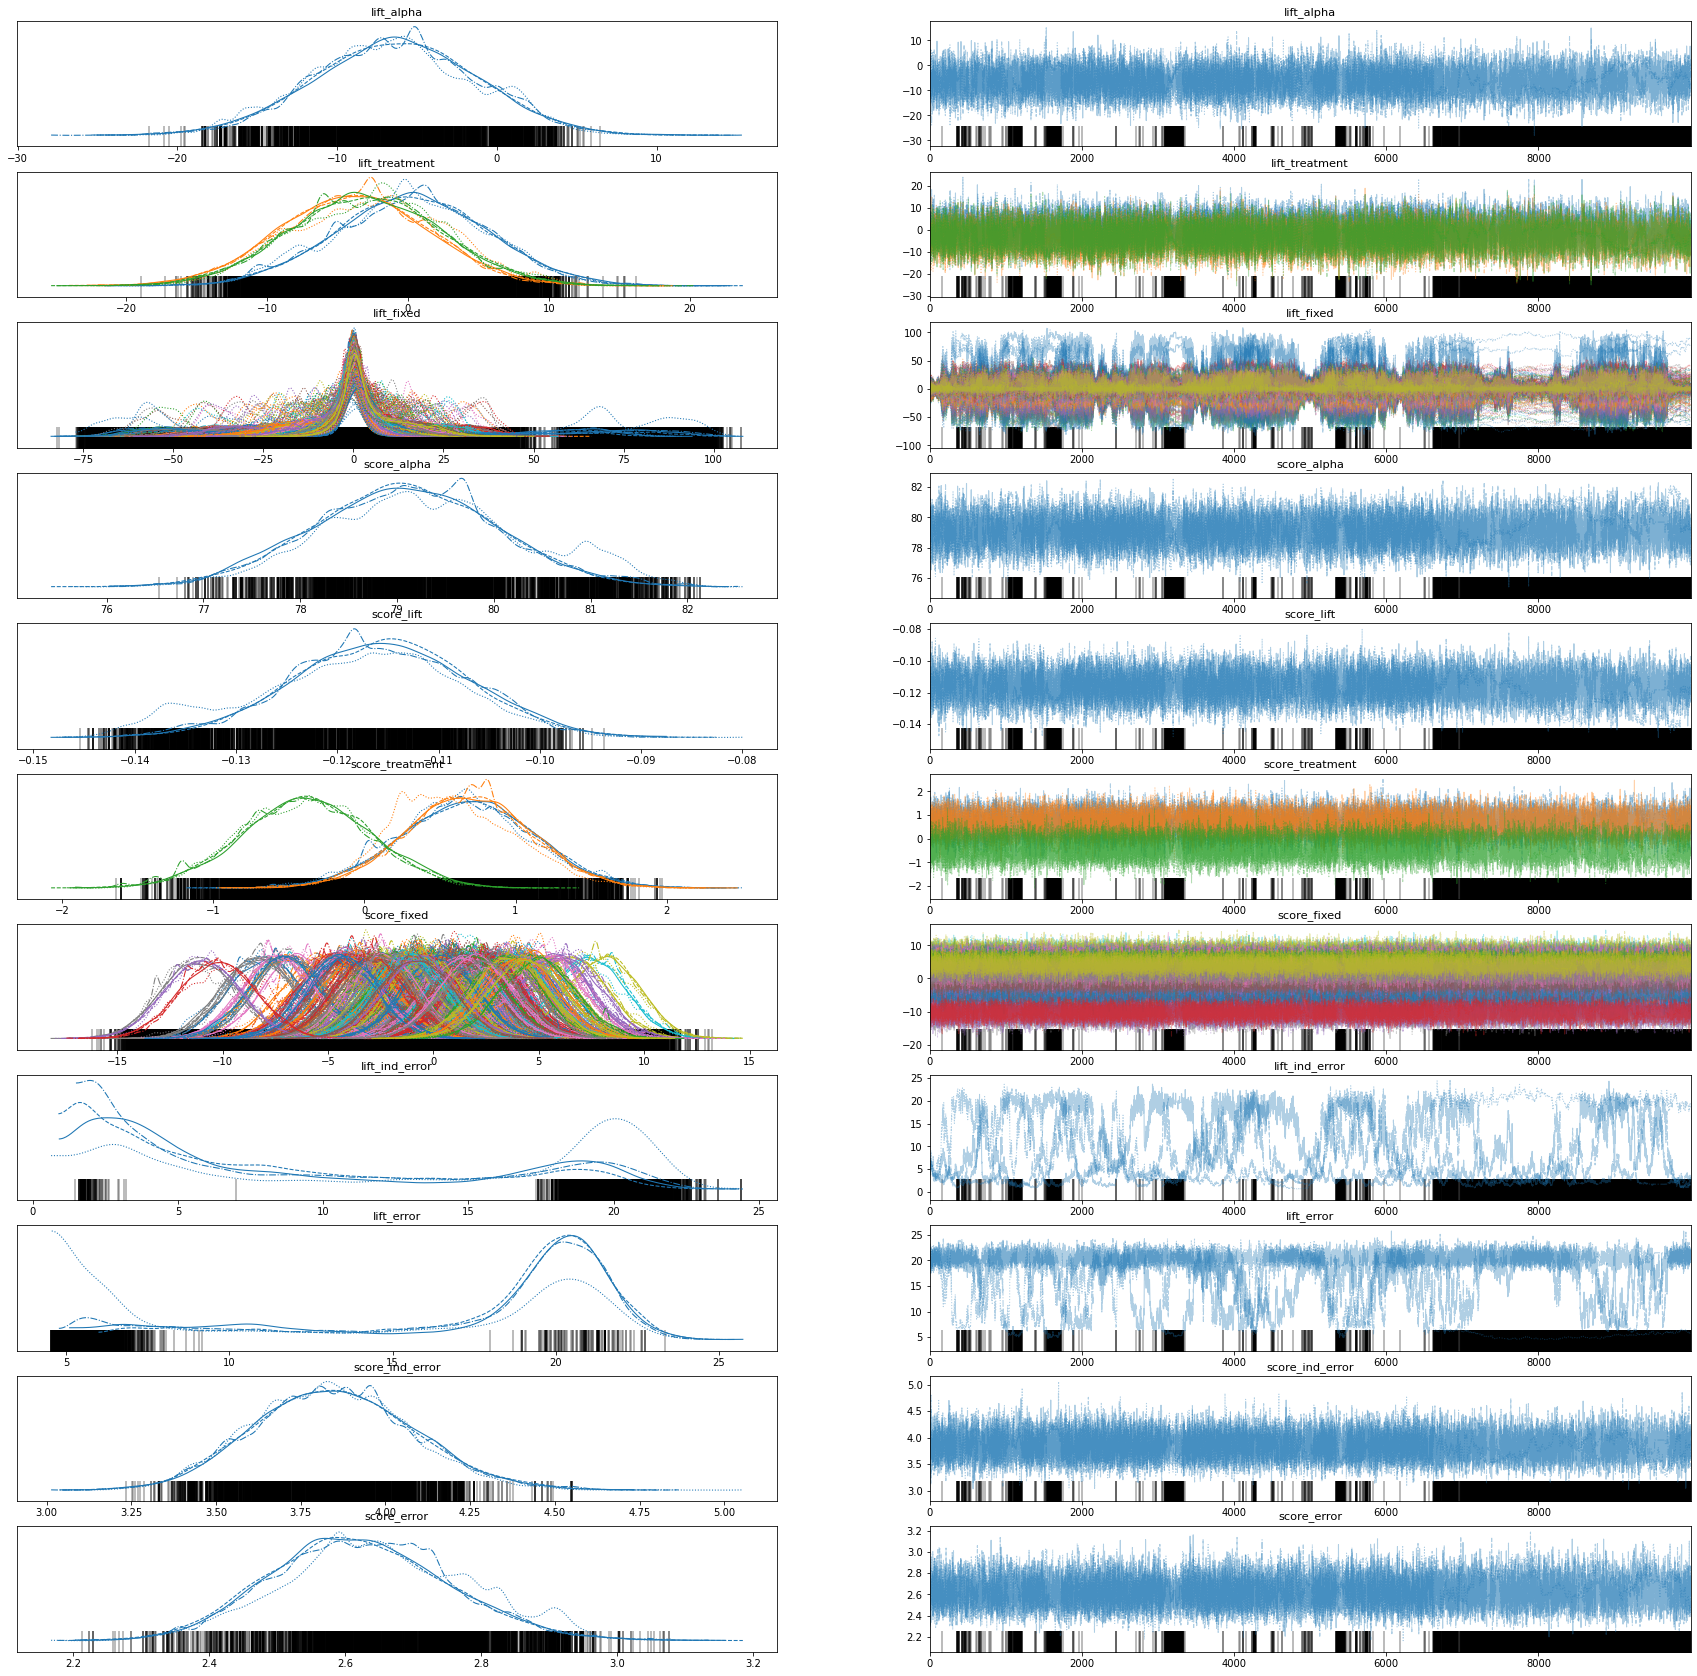

In [14]:
az.plot_trace(trace, figsize=(30,30))